# h3_ENB_combine
Combine interactions extarct from both dataset and compare the precision and the recall

In [1]:
import pandas as pd
import import_ipynb
import h1_ENB_occ as h1 
import h2_ENB_gen as h2 
import pickle
import numpy as np
import csv
from scipy.sparse import csr_matrix
import nltk
nltk.download('wordnet')
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.tag import StanfordNERTagger
from nltk.tokenize import MWETokenizer
import string
import collections
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk import ngrams
import pandas as pd 
import re 

importing Jupyter notebook from h1_ENB_occ.ipynb
importing Jupyter notebook from h2_ENB_gen.ipynb
importing Jupyter notebook from c1_extract_text.ipynb
importing Jupyter notebook from a1_tools.ipynb
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def extract_gen(issue_number):
    """ Extract for a specific issue the dataframe and the sentence on both datasets. """
    frames1 = []
    frames2 = []
    s1 = []
    s2 = []
    df1 = h1.extract_relationships_count(issue_number)
    df2 = h2.interactions(issue_number)
    frames1.append(df1[0])
    frames2.append(df2[0]) 
    s1.append(df1[1])
    s2.append(df2[1])
    return pd.concat(frames1), pd.concat(frames2), s1, s2


In [3]:
def clean_tp(sentence):
    """ Clean the sentence by removing special char."""
    s = re.sub('\n',' ',sentence)
    s = re.sub(r'\\',' ',s)
    s = s.replace("\r\n\s\s+"," ")
    s = s.replace("\r\n"," ")
    s = s.replace('\t','')
    s = s.replace("\s\s+"," ")
    s = s.replace("\\."," ")
    s = s.replace("\\r\\n"," ")
    p = re.compile(r'<.*?>')
    return p.sub('', s)

In [4]:
ENTITIES = [s.replace('\n','') for s in list(open('Files/entities_interactions.txt'))]
SUPPORTS_LINKS = ['with','and','for the','on behalf of the','supported by','speaking for the','for several']
OPPOSITION_LINKS= ['opposed by','while','opposed by the']
LIST_TAGS = ['IN', 'CC', 'NN', 'NNP', 'JJ','NNPS','MD','VBP','VB','VBZ','VBD','RB','VBN','PRP', 'NNS']
PARTY_GROUPINGS = sorted(set([s.replace('\n','').upper() for s in list(open('Files/party_groupings.txt'))] + [s.replace('\n','').title() for s in list(open('Files/party_groupings.txt'))] + [s.replace('\n','') for s in list(open('Files/party_groupings.txt'))]))
PARTIES = sorted(set(ENTITIES).difference(set(PARTY_GROUPINGS)))

In [5]:
def tokenize_sentence(sentence, country):
    """Split the sentence in a way that the entities are together and will be able to be detected."""
    # Extract list entities
    
    tokens_entities = [l.split(' ') for l in ENTITIES]
    tokens_entities.append(['on','behalf','of'])
    tokens_entities.append(['on','behalf','of','the'])
    tokens_entities.append(['for'])
    tokens_entities.append(['for','the'])
    tokens_entities.append(['speaking','for'])
    tokens_entities.append(['speaking','for','the'])
    tokens_entities.append(['US','$'])
    tokens_entities.append(['concerns', 'of', 'the'])
    tokens_entities.append(['concerns', 'of'])
    tokens_entities.append(['spoke','with'])
    tokens_entities.append(['for', 'a', 'number','of', 'members' ,'of' ,'the'])
    tokens_entities.append(['for', 'several'])
    tokens_entities.append(['speaking','on','behalf', 'of', 'the'])  
    tokens_entities.append(['supported','by'])
    tokens_entities.append(['supported','by','the'])
    tokens_entities.append(['opposed','by'])
    tokens_entities.append(['opposed','by','the'])
    tokens_entities.append(['proposed','by','the'])
    tokens_entities.append(['proposed','by'])
    tokenizer1 = MWETokenizer(tokens_entities, separator=' ')
    tokenizer2 = MWETokenizer([['G-77','CHINA']], separator='/')
    tokenizer3 = MWETokenizer([['G-77/',' CHINA']], separator=' ')
    
    if(type(sentence) == list):
        line = sentence[0].replace(",","")
    else: 
        line = sentence.replace(",","")
    line_splited = word_tokenize(line)
    tokens = tokenizer1.tokenize(line_splited) 
    tokens = tokenizer2.tokenize(tokens) 
    tokens = tokenizer3.tokenize(tokens) 
    

    return tokens

In [6]:
def similarities(d_i,d_j):
    """ Compute the similarities between both vectors. """
    return np.dot(d_i.T,d_j)/(np.linalg.norm(d_i)*np.linalg.norm(d_j))

In [7]:
def define_df(df_original, so, df_generated, sg):
    """ Combine the two dataframes and create indices for each sentences. """
    
    se_orig = set(df_original['sentences'].to_numpy())
    se_orig = ["orig - "+x for x in se_orig]
    df_original['sentences'] = df_original['sentences'].apply(lambda x :"orig - "+x )
    
    se_gen = set(df_generated['sentences'].to_numpy())

    issues = df_original['issue'].drop_duplicates(keep = 'first')
    d_original = pd.DataFrame()
    d_generated= pd.DataFrame()
    
    #Split sentence
    s1 = [tokenize_sentence(x, True) for x in se_orig]
    s2 = [tokenize_sentence(x, True) for x in se_gen]

    d_original['sentences_splited'] = s1
    d_generated['sentences_splited'] = s2
    d_original['sentences'] = se_orig
    d_generated['sentences'] = se_gen

    sent_id_o = np.arange(len(se_orig))
    sent_id_g = len(se_orig) + np.arange(len(se_gen))
    d_combines = pd.concat([d_original,d_generated])
    return d_combines, sent_id_o, sent_id_g

In [8]:
def find_word(sentence, word):
    """ check if there is a speicific word in the sentence. """
    if(sentence.count(word) > 0):
        return 1
    else:
        return 0

In [9]:
def find_n(list_sentences, word):
    """ Count the number of time each word is in one sentence. """
    return np.sum([find_word(sentence, word) for sentence in list_sentences])

In [10]:
def define_max_k(description):
    """ Find .... """
    counter=collections.Counter(description)
    return counter.most_common(1)[0][1]

In [11]:
def count_(word,description,max_k):
    return description.count(word)/max_k    

In [12]:
def define_TFIDf_matrix(d_combines, sent_id_o, sent_id_g):

    N = max(sent_id_g) +1

    #Find all the words in all the documents
    sentences = d_combines['sentences_splited'].to_numpy().flatten()
    words = []
    for d in sentences:
        words += d
    words = set(words)
    #Data frame with words and their index
    d = {'word': list(words), 'index': np.arange(len(words))}
    df_words =  pd.DataFrame(data=d)

    indices = np.arange(N)
    d_combines['index'] = indices


    dictionary_doc =dict(zip(indices,d_combines['sentences_splited'].to_numpy()))
    dictionary_max_k =dict(zip(indices,d_combines.apply(lambda x: define_max_k(x['sentences_splited']),axis =1 )))
    df_words['n'] = [find_n(d_combines['sentences_splited'].to_numpy(), w) for w in df_words['word'].to_numpy()]

    df_words['IDF'] = df_words['n'].apply(lambda x: - np.log2(int(x)/N))

    for id_d in indices:
        df_words[str(id_d)] = [count_(w,dictionary_doc[id_d],dictionary_max_k[id_d]) for w in df_words['word'].to_numpy() ]

    df_words_TF = df_words.drop(['word', 'index','n','IDF'], axis=1)
    matrix_words_TF = df_words_TF.to_numpy()
    matrix_words_IDF = df_words['IDF'].to_numpy()
    marix_TFIDF = (matrix_words_TF.T * matrix_words_IDF).T
    return marix_TFIDF

In [13]:
def define_dict_sentences(d_combines, df_original, df_generated, matrix_TFIDF, sent_id_o, sent_id_g):
    """Create dictionaries that will help to retrieve sentences and interactions from the TFIDF matrix. """
    dict_sentence_idx = d_combines.set_index('sentences')['index'].to_dict()
    dict_idx_sentence = d_combines.set_index('index')['sentences'].to_dict()
    # Similarties with high Tf_DFI score
    keys = []
    values = []

    for i in range(len(sent_id_g)):
        # Index of sentence in generated
        test_idx = sent_id_g[i]

        #Find sentence with best similarities
        test_v = matrix_TFIDF[:,test_idx ]
        similarities_list = [similarities(matrix_TFIDF[:,i],test_v) for i in sent_id_o ]
        #no sentences in common
        if(len(similarities_list) ==0):
            return dict(), dict(), dict(), 0,0 
        test_s = np.argmax(similarities_list)

        keys.append(test_idx)
        values.append(test_s)
    #dict with key = index generated | value = index original 
    dictionary_id = dict(zip(keys, values))
    #Find the corresponding index of the sentence in the issue

    df_generated['se_index'] = df_generated['sentences'].apply(lambda x :dict_sentence_idx[x])
    
    df_original['se_index'] = df_original['sentences'].apply(lambda x : dict_sentence_idx[x])
    #return df_original, df_generated, d_combines['sentences'].to_numpy()
    return dictionary_id, dict_sentence_idx, dict_idx_sentence, df_original, df_generated

In [14]:
def find_differences_issue(df_original, df_generated, dict_id):
    """Function that find all interactions not present in the original and present in the generated dataset and vice versa. """
    frames = []
    num_o = 0
    num_g = 0
    for index_g in dict_id:

        df_g = df_generated[df_generated.apply(lambda x: x['se_index'] == index_g, axis=1)]
        df_o = df_original[df_original.apply(lambda x: x['se_index'] == dict_id[index_g], axis=1)]
        df_g = df_g.drop(['behalf','support','agreement','opposition','criticism','se_index'], axis = 1)
        df_o = df_o.drop(['behalf','support','agreement','opposition','criticism','se_index'], axis = 1)

        num_o += len(df_o['cooperation'].to_numpy())
        num_g += len(df_g['cooperation'].to_numpy())
        delta_og = 0
        delta_go = 0 

        df_concat = pd.concat([df_o,df_g])
        df_concat = df_concat.drop_duplicates(subset=['id_ca','id_cb','cooperation'], keep=False)

        frames.append(df_concat)
        df_result = pd.concat(frames)
        delta_go += len(df_concat[df_concat.apply(lambda x: x['type'] == 'generated', axis=1)].to_numpy())
        delta_og += len(df_concat[df_concat.apply(lambda x: x['type'] == 'original', axis=1)].to_numpy())

    return df_result, delta_go, delta_og, num_o, num_g

In [15]:
def extract_from_csv_list_issues(csv_file):
    """ Extract from "csv_file" all the html link to be able to extract all the <p> tags. """
    f = open(csv_file)
    csv_f = csv.reader(f)
    list_pt = []
    return list(csv_f)[1:]

In [16]:
def find_summary():
    """ Function that find the specific date of one issue. """
    list_meetings = extract_from_csv_list_issues('Text/list_meetings.csv')
    num = []
    meetings = []
    for i in range(len(list_meetings)):

        if(list_meetings[i][5] == 'Summary'):

            num.append(list_meetings[i][4])
        else :
           meetings.append(int(list_meetings[i][4]))


    return num, meetings

In [24]:
def extract_list_issue():
    """Find all issue in the original dataset and also the one that our program is able analyze. """
    summaries, list_generated = find_summary()
    with open("Text/ENB_relationships.txt") as infile:
        k=0
        num = []
        for line in infile:
            x = line.split('\t')[:26]

            #if(k > 0 and 50 ==int(x[23])):
            if(k > 0 and  45 < int(x[23]) and int(x[23]) < 594 and not (378 <= int(x[23]) and int(x[23]) <= 382)):
            

                num.append(int(x[23]))
            k +=1
        list_issues = list(set(num))
        list_issue = [s for s in list_issues if str(s) not in summaries]
        issues = set(list_issue).intersection(set(list_generated))
        return issues

In [25]:
def precision_recall_dataset():
        """Find the precision and the recall for the dataset. """
        list_issue_num = extract_list_issue()
        zeros = []
        small = []
        precision = []
        recall = []
        diff = []
        num_gen_had = []
        num_o_had = []
        diff_sent_o = []
        for issue_number in sorted(list_issue_num):
                print(issue_number)
                #Create the dataframes and compare the the two datsets on one issue
                df_original, df_generated, so, sg = extract_gen(issue_number)
                num_sent_orig = len(set(so[0]))
                number_original = len(df_original['issue'].to_numpy())
                number_generated = len(df_generated['issue'].to_numpy())
                df_combines, sent_id_o, sent_id_g =  define_df(df_original, so, df_generated, sg)
                num_sent_kept = len(sent_id_g)

                if(len(sent_id_g) ==0):
                        print('sent_id_g zero')
                        p = 1
                        r = 0
                        precision.append(p)
                        recall.append(r)
                else : 
                        if(len(sent_id_o)==0):
                                print('sent_id_o zero')
                                p = 0 
                                r = 1
                                recall.append(p)
                                precision.append(r)
                        else :
                                #old nadame dictionary_sentences_id = dict_id
                                marix_TFIDF = define_TFIDf_matrix(df_combines, sent_id_o, sent_id_g)
                                dict_id, dict_sentence_idx, dict_idx_sentence, df_original, df_generated = define_dict_sentences(df_combines, df_original, df_generated, marix_TFIDF, sent_id_o, sent_id_g)



                                df_results, delta_go, delta_og, num_o, num_g = find_differences_issue(df_original, df_generated, dict_id)
                                precision.append((num_g - delta_go)/num_g)
                                recall.append((num_o - delta_og)/num_o)
                                num_gen_had.append((num_g, delta_go))
                                num_o_had.append((num_o, delta_og))
                                diff_sent_o.append((num_sent_orig, num_sent_kept))
            


        return precision, recall, num_gen_had,num_o_had, diff_sent_o

In [26]:
precision, recall, num_gen_had, num_o_had, diff_sent_o = precision_recall_dataset()

47
48
49
50
sent_id_g zero
53
57
58
59
61
62
63
64
65
67
68
69
sent_id_g zero
70
71
72
73
sent_id_g zero
74
sent_id_g zero
75
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
Cote d'Ivoire
78
79
80
81
82
83
84
85
88
89
90
91
92
93
94
96
100
101
102
103
104
105
106
107
108
109
113
114
115
116
117
118
119
120
121
128
129
130
131
132
133
134
135
136
138
139
142
143
144
145
146
147
148
149
150
153
154
155
156
157
158
159
160
161
167
170
172
173
174
179
180
181
182
183
184
185
186
187
188
193
194
195
196
197
198
199
202
203
204
205
206
207
208
212
213
214
Serbia
Serbia
Montenegro
Montenegro
215
216
217
218
222
223
not added c_a : 'ALBANIA AND MOLDOVA GROUP'
not added 

In [27]:
def plot_acc(x,y):
    """Plot precision or recall between two datasets"""
    figsize = (16,9)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    csfont = {'fontname':'Helvetica','fontsize':'18' }
    hfont = {'fontname':'Helvetica','fontsize':'16'}
    plt.title('Precision sentence by sentence aggregated by issues',**csfont)
    plt.xlabel('Issues in chronological order', **hfont)
    plt.ylabel('Precentage', **hfont)
    plt.scatter(x,y, color ='dodgerblue')
    plt.show()

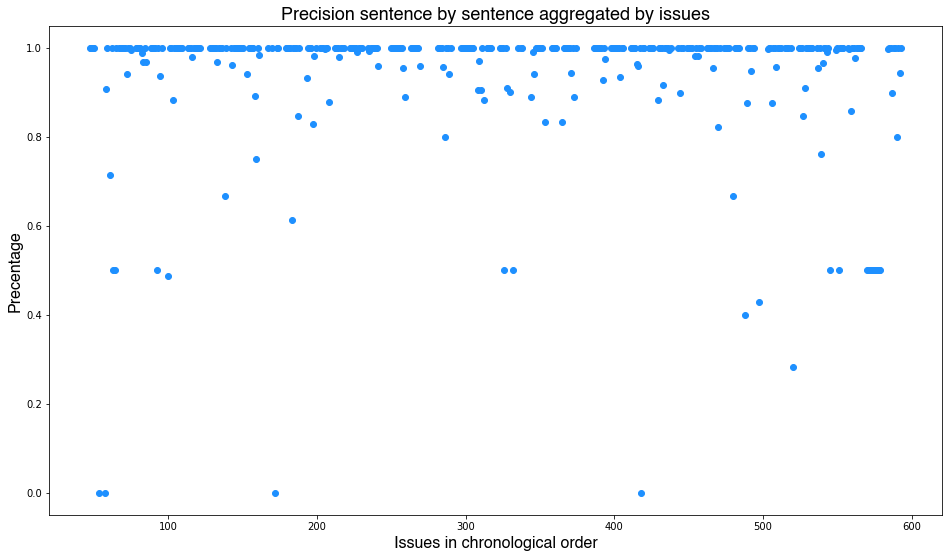

In [28]:
import matplotlib.pyplot as plt
list_issue_num = extract_list_issue()
plot_acc(sorted(list_issue_num),precision)

In [29]:
print("recall ", np.mean(recall))
print("precision ",np.mean(precision))

recall  0.9106062399065635
precision  0.9413217111517671
